In [1]:
import os
import torch
import torchvision

import h5py
import deepdish as dd

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision

import matplotlib.pyplot as plt;

import numpy as np


from PIL import Image
from sklearn.metrics import roc_auc_score

import tempfile
import time
import pickle as pkl;

In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /usr/remote/anaconda-3.7-2020-05-28/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /usr/

In [2]:
n_epochs = 40
patience_limit = 20
patience = 0
batch_size_train = 16# was 64
batch_size_test = 16
learning_rate = 0.001
momentum = 0.1
log_interval = 31
tt_factor = 0.8
orientation = 'AP'
num_imgs = 5000

disease_to_train = 'all_diseases_all_imgs'
model_path = './data/saved_models/' + disease_to_train + '.pth'

random_seed = 1
#torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [3]:
''' 
    NOTES: 
    - it's "No Finding" not "No findings"
    - it's "Pleural_Thickening" not "Pleural_thickening"
    - it's not "Nodule Mass", but rather "Nodule" and "Mass" separately
'''
disease_map = {"Atelectasis" : 0, "Consolidation" : 1, "Infiltration" : 2, "Pneumothorax": 3, "Edema": 4,
               "Emphysema": 5, "Fibrosis": 6, "Effusion" : 7, "Pneumonia" : 8, "Pleural_Thickening" : 9,
               "Cardiomegaly" : 10, "Nodule" : 11, "Mass" : 12, "Hernia" : 13, "No Finding" : 14 }


In [4]:
dis_small_map = {'Cardiomegaly': 0, 'Effusion': 1, 'Mass': 2, 'Nodule': 3, 'Atelectasis': 4, 'No Finding': 5}

In [5]:
class GetLoader_w_val(torch.utils.data.Dataset):
    '''
        NOTE: I hardcoded this one a bit, basically splits validation set in half and gives it to test set
    
        Params: data - the data dictionary
                view - the orientation you want to look at
                diseases - the diseases you would like to look at
                num_imgs - the number of images of each disease you would like
                factor - the ratio of training and testing data
                typ - 0 for training, 1 for testing
    '''
    def __init__(self, data, view, diseases, num_imgs, factor, typ, transforms=None):
        
        #private data
        self.root = os.path.join('data/sorted_images',)
        self.data = data # dict object
        self.transforms = transforms
        self.len_data = 0
        datalist = []
        
        #Creating the datalist
        for i in range(len(diseases)):                
            
            if len(data[view][diseases[i]]) <= num_imgs: #if the folder has less images than the desired number of images
                if typ == 0:
                    start = 0
                    end = int(len(data[view][diseases[i]])*factor)
                elif typ == 1:
                    start = int(len(data[view][diseases[i]])*factor)
                    end = int(len(data[view][diseases[i]])*factor + len(data[view][diseases[i]])*(1-factor) / 2)
                else:
                    start = int(len(data[view][diseases[i]])*factor + len(data[view][diseases[i]])*(1-factor) / 2)
                    end = -1
            else:
                if typ == 0:
                    start = 0
                    end = int(num_imgs*factor)
                elif typ == 1:
                    start = int(num_imgs*factor)
                    end = int(num_imgs*factor + num_imgs*(1-factor) / 2)
                else:
                    start = int(num_imgs*factor + num_imgs*(1-factor) / 2)
                    end = num_imgs
                    
            #print('dis: ', diseases[i], ', type: ', typ, ', start: ', start, ', end:', end)
            print('disease: ', diseases[i], 'num images used: ', min(len(data[view][diseases[i]]), num_imgs))
            
            #class_weights[disease_map[diseases[i]]] = num_imgs / min(len(data[view][diseases[i]]), num_imgs)
            
            datalist.append(self.data[view][diseases[i]][start:end])
        
        for item in datalist:
            self.len_data += len(item)
        
        
        self.img_paths = []
        self.img_labels = []
        
        for dis in datalist:
            for data in dis:
                #creating the image path
                data['img_path'] = os.path.join(self.root, data['classes'][0], view, data['img_name'])            
                diseases_item = data['classes']

                one_hot = np.zeros(6)
                for d in diseases_item:
                    if d in diseases:
                        hot_index = dis_small_map[d]
                        one_hot[hot_index] = 1

                self.img_paths.append(data['img_path'])
                self.img_labels.append(torch.Tensor(one_hot))


    def __getitem__(self, item):
        
        img_path, img_label = self.img_paths[item], self.img_labels[item]
  
        # TODO: fix this hot fix -> recreate data object with underscore in name
        img_path = img_path.replace('No Finding', 'No_Finding')
        try:
            img = Image.open(img_path).convert('RGB')
        except:
            img_path = img_path.replace('/AP/', '/PA/')
            img = Image.open(img_path).convert('RGB')
            
        self.cur_img_path = img_path

        if self.transforms is not None:
            for t in self.transforms:
                img = t(img)

        return img, img_label
    
    def get_img_path(self):
        return self.cur_img_path

    def __len__(self):
        return self.len_data

### load in datasets

In [6]:
pkl_load = open('dataset.pickle', 'rb')
data = pkl.load(pkl_load)
pkl_load.close()
print("data loaded in successfully")

data loaded in successfully


In [7]:
class_weights = torch.Tensor(np.ones(6))

In [8]:
transforms = [torchvision.transforms.ToTensor()] # no longer grayscale conversion
#0 = train, 1 = test
dataset_train = GetLoader_w_val(data, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
                          num_imgs, tt_factor, 0, transforms)
dataset_valid = GetLoader_w_val(data, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
                          num_imgs, tt_factor, 1, transforms)
dataset_test = GetLoader_w_val(data, orientation, list(['Cardiomegaly', 'Effusion', 'Mass', 'Nodule', 'Atelectasis', 'No Finding']),
                          num_imgs, tt_factor, 2, transforms)
print(len(dataset_train))
print(len(dataset_valid))
print(len(dataset_test))

disease:  Cardiomegaly num images used:  1213
disease:  Effusion num images used:  5000
disease:  Mass num images used:  2215
disease:  Nodule num images used:  2154
disease:  Atelectasis num images used:  5000
disease:  No Finding num images used:  5000
disease:  Cardiomegaly num images used:  1213
disease:  Effusion num images used:  5000
disease:  Mass num images used:  2215
disease:  Nodule num images used:  2154
disease:  Atelectasis num images used:  5000
disease:  No Finding num images used:  5000
disease:  Cardiomegaly num images used:  1213
disease:  Effusion num images used:  5000
disease:  Mass num images used:  2215
disease:  Nodule num images used:  2154
disease:  Atelectasis num images used:  5000
disease:  No Finding num images used:  5000
16465
2057
2057


In [9]:
train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size_train, shuffle=True, num_workers=1)
test_loader = torch.utils.data.DataLoader(dataset_test, batch_size=batch_size_train, shuffle=True, num_workers=1)
valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=batch_size_train, shuffle=True, num_workers=1)
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

1030
129
129


In [10]:
# the 'No Findings' class is given a 3x weight value since more relevant,
# while other class weights are based on number of images available
# did it by hand for this subset classifier
class_weights[0] = 5000 / 1213 # cardiomegaly
class_weights[2] = 5000 / 2215 # mass
class_weights[3] = 5000 / 2214 # nodule
class_weights[5] = 1.2
class_weights

tensor([4.1220, 1.0000, 2.2573, 2.2584, 1.0000, 1.2000])

In [11]:
model = torch.hub.load('pytorch/vision:v0.6.0', 'resnet18', pretrained=False)

Using cache found in /home/npp002/.cache/torch/hub/pytorch_vision_v0.6.0


In [12]:
# trying without this to see if optimization was the issue
# for param in model.parameters():
#     param.requires_grad = False

In [13]:
model.fc = nn.Sequential(*[
    nn.Linear(in_features=512, out_features=6, bias=True),
    nn.Sigmoid(),
])
model.children;

In [14]:
network = model
#network = torchvision.models.vgg11(pretrained=False)
#network.fc = nn.Linear(512, 15)
network = torch.nn.DataParallel(network)
network.cuda()
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
print('Trainable params: {}'.format(sum(p.numel() for p in network.parameters() if p.requires_grad)))

Trainable params: 11179590


In [15]:
## source: https://gist.github.com/the-bass/cae9f3976866776dea17a5049013258d
def hard_binary_accuracy(batch, labels):
    batch = torch.round(batch)
    confusion_matrix = batch / labels
    
    """ Returns the confusion matrix for the values in the `prediction` and `truth`
    tensors, i.e. the amount of positions where the values of `prediction`
    and `truth` are
    - 1 and 1 (True Positive)
    - 1 and 0 (False Positive)
    - 0 and 0 (True Negative)
    - 0 and 1 (False Negative)
    """

    confusion_matrix = batch / labels
    # Element-wise division of the 2 tensors returns a new tensor which holds a
    # unique value for each case:
    #   1     where prediction and truth are 1 (True Positive)
    #   inf   where prediction is 1 and truth is 0 (False Positive)
    #   nan   where prediction and truth are 0 (True Negative)
    #   0     where prediction is 0 and truth is 1 (False Negative)

    true_positives = torch.sum(confusion_matrix == 1).item()
    false_positives = torch.sum(confusion_matrix == float('inf')).item()
    true_negatives = torch.sum(torch.isnan(confusion_matrix)).item()
    false_negatives = torch.sum(confusion_matrix == 0).item()

    return true_positives, false_positives, true_negatives, false_negatives


In [16]:
b = torch.Tensor([[[1, 1], [0, 0]], 
                  [[1, 1], [0, 0]]])

l = torch.Tensor([[[1, 1], [0, 0]], 
                  [[1, 1], [0, 0]]])
hard_binary_accuracy(b, l)

(4, 0, 4, 0)

In [17]:
def train(epoch):

    network.train()
    train_losses = []
    num_tested = 0
    net_loss = 0
    
    total_true_pos, total_false_pos, total_true_neg, total_false_neg = 0, 0, 0, 0
    
    for batch_idx, (data, target) in enumerate(train_loader):  # (output - actual )
        
        if torch.cuda.is_available:
            data, target = data.cuda(), target.cuda()

        output = network(data)
        
        #criterion = torch.nn.BCELoss(weight=torch.Tensor(class_weights).cuda())  # 1 0 1 0 0 0 
        criterion = torch.nn.BCELoss()
        loss = criterion(output, target)
        loss.backward()
        
        net_loss += loss.clone().detach().cpu().item()
        train_losses.append(loss.item())

        num_tested += len(data)
        
        #if batch_idx % 1 == 0 or batch_idx == len(train_loader) - 1:
        optimizer.step()
        optimizer.zero_grad()

        pred = output.clone().detach().clone().cpu()
        target = target.cpu()

        true_pos, false_pos, true_neg, false_neg = hard_binary_accuracy(pred, target)
        total_true_pos += true_pos
        total_false_pos += false_pos
        total_true_neg += true_neg
        total_false_neg += false_neg
            
    net_loss /= (batch_size_train * len(train_loader))
    return net_loss, total_true_pos, total_false_pos, total_true_neg, total_false_neg


In [18]:
def test():
    
    network.eval()
    test_losses = []
    net_loss = 0    

    total_true_pos, total_false_pos, total_true_neg, total_false_neg = 0, 0, 0, 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            if torch.cuda.is_available:
                data, target = data.cuda(), target.cuda()
            
            output = network(data)
            
            #criterion = torch.nn.BCELoss(weight=torch.Tensor(class_weights).cuda())
            criterion = torch.nn.BCELoss()

            net_loss += criterion(output, target).item()

            pred = output.detach().clone().cpu()
            target = target.cpu()
            
            true_pos, false_pos, true_neg, false_neg = hard_binary_accuracy(pred, target)
            total_true_pos += true_pos
            total_false_pos += false_pos
            total_true_neg += true_neg
            total_false_neg += false_neg
            
        
    net_loss /= (batch_size_test * len(test_loader))
    return net_loss, total_true_pos, total_false_pos, total_true_neg, total_false_neg


In [19]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
print(torch.cuda.is_available())

1
GeForce RTX 2080 Ti
True


In [20]:
train_sample_size = len(train_loader) * batch_size_train
test_sample_size = len(valid_loader) * batch_size_test
print(train_sample_size, test_sample_size)

16480 2064


In [21]:
print("Starting Training...")
begin_time = time.time()

min_loss_test = 999

train_losses = []
test_losses = []

train_acc = []
test_acc = []

train_true_pos = []
train_false_pos = []
train_true_neg = []
train_false_neg = []

test_true_pos = []
test_false_pos = []
test_true_neg = []
test_false_neg = []

best_model_file = tempfile.NamedTemporaryFile(mode='w+b', delete=False)
torch.save(network.state_dict(), best_model_file.name)



for epoch in range(1, n_epochs + 1):
    start_time = time.time()
    network.load_state_dict(torch.load(best_model_file.name))

    loss_train, true_pos_train, false_pos_train, true_neg_train, false_neg_train = train(epoch)
    loss_test, true_pos_test, false_pos_test, true_neg_test, false_neg_test = test()
    
    #print("tp / fp / tn / fn : ", true_pos_test, false_pos_test, true_neg_test, false_neg_test )
    train_losses.append(loss_train)
    test_losses.append(loss_test)
    
    n_correct_train = true_pos_train + true_neg_train
    n_correct_test = true_pos_test + true_neg_test
    
    acc_train = 100. * n_correct_train / (n_correct_train + false_pos_train + false_neg_train)
    acc_test = 100. * n_correct_test / (n_correct_test + false_pos_test + false_neg_test)
    
    train_acc.append(acc_train)
    test_acc.append(acc_test)
    
#     true_pos_rate_train = 100. * true_pos_train / (true_pos_train + false_pos_train)
#     true_neg_rate_train = 100. * true_neg_train / (true_neg_train + false_neg_train)
#     false_pos_rate_train = 100. * false_pos_train / (false_pos_train + true_neg_train)
#     false_neg_rate_train = 100. * false_neg_train / (false_neg_train + true_pos_train)
    
#     true_pos_rate_test = 100. * true_pos_test / (true_pos_test + false_pos_test)
#     true_neg_rate_test = 100. * true_neg_test / (true_neg_test + false_neg_test)
#     false_pos_rate_test = 100. * false_pos_test / (false_pos_test + true_neg_test)
#     false_neg_rate_test = 100. * false_neg_test / (false_neg_test + true_pos_test)

    train_true_pos.append(true_pos_train)
    train_false_pos.append(false_pos_train)
    train_true_neg.append(true_neg_train)
    train_false_neg.append(false_neg_train)

    test_true_pos.append(true_pos_test)
    test_false_pos.append(false_pos_test)
    test_true_neg.append(true_neg_test)
    test_false_neg.append(false_neg_test)
        
    auc_train = roc_auc_score

        
    elapsed_time = time.time() - start_time
    
    print("-----------Epoch " + str(epoch) + " (time =", round(elapsed_time, 2), "s  aka  ", round(elapsed_time / 60, 2), " mins) ----------------")
    print('Train set: Avg. loss: {:.4f},  Accuracy: {}/{} ({:.2f}%)'.format(
        loss_train, n_correct_train, (n_correct_train + false_pos_train + false_neg_train), acc_train))
#     print('''
#           True Positive: {:.2f}%
#           True Negative: {:.2f}%
#           False Positive: {:.2f}%
#           False Negative {:.2f}%
#           '''.format(true_pos_rate_train, true_neg_rate_train, false_pos_rate_train, false_neg_rate_train))    
    print('\nTest set:  Avg. loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)'.format(
        loss_test, n_correct_test, (n_correct_test + false_pos_test + false_neg_test), acc_test))
#     print('''
#           True Positive: {:.2f}%
#           True Negative: {:.2f}%
#           False Positive: {:.2f}%
#           False Negative {:.2f}%
#           '''.format(true_pos_rate_test, true_neg_rate_test, false_pos_rate_test, false_neg_rate_test))
    
    
    if loss_test < min_loss_test:
        min_loss_test = loss_test
        patience = 0
        best_epoch = epoch
        
        print('Epoch {} --- saving new best model: test loss = {}'.format(epoch, loss_test))
        torch.save(network.state_dict(), best_model_file.name)
    else:
        patience += 1
        
    if patience == patience_limit:
        print('Breaking on patience={}'.format(patience))
        break
        

print('Reloading best model from epoch {}'.format(best_epoch))
network.load_state_dict(torch.load(best_model_file.name))

end_time = time.time() - begin_time

print("Training complete (time =", round(end_time, 2), "s)")
torch.save(network.state_dict(), 
           os.path.join(model_path))
print("Saved model to {}".format(model_path))

    

Starting Training...
-----------Epoch 1 (time = 531.99 s  aka   8.87  mins) ----------------
Train set: Avg. loss: 0.0355,  Accuracy: 76084/98790 (77.02%)

Test set:  Avg. loss: 0.0324, Accuracy: 9457/12342 (76.62%)
Epoch 1 --- saving new best model: test loss = 0.032350075886000036
-----------Epoch 2 (time = 528.62 s  aka   8.81  mins) ----------------
Train set: Avg. loss: 0.0348,  Accuracy: 76679/98790 (77.62%)

Test set:  Avg. loss: 0.0323, Accuracy: 9454/12342 (76.60%)
Epoch 2 --- saving new best model: test loss = 0.03226237526062385
-----------Epoch 3 (time = 527.87 s  aka   8.8  mins) ----------------
Train set: Avg. loss: 0.0345,  Accuracy: 76673/98790 (77.61%)

Test set:  Avg. loss: 0.0320, Accuracy: 9449/12342 (76.56%)
Epoch 3 --- saving new best model: test loss = 0.03204386487834213
-----------Epoch 4 (time = 526.9 s  aka   8.78  mins) ----------------
Train set: Avg. loss: 0.0345,  Accuracy: 76689/98790 (77.63%)

Test set:  Avg. loss: 0.0320, Accuracy: 9443/12342 (76.51%)

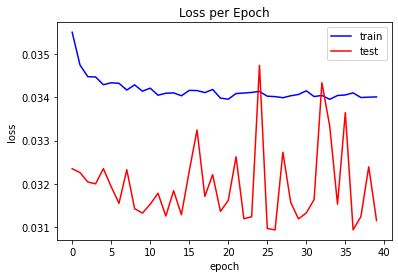

In [22]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Loss per Epoch")
plt.plot(train_losses, "-b",  label="train")
plt.plot(test_losses, "-r", label="test")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(loc="upper right")

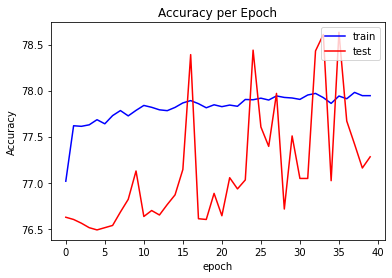

In [23]:
import matplotlib.pyplot as plt

plt.figure()
plt.title("Accuracy per Epoch")
plt.plot(train_acc, "-b", label="train")
plt.plot(test_acc, "-r", label="test")
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.legend(loc="upper right")